# Hazard: Tropical Cyclone Surge

`TCSurge` class contains surges generated by tropical cyclones. Given a `TropCyclone` instance, it computes the surges for each historical and/or synthetic event at every centroid. `TCSurge` inherits from `Hazard` and has an associated hazard type `TS`.

## The model

First the surge height is computed from the tropical cyclone's gust field following an approximation to the [SLOSH](http://www.nhc.noaa.gov/surge/slosh.php) model as follows:

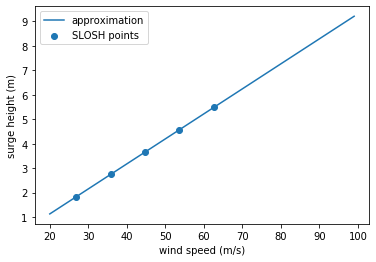

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# conversion factors
mph2ms = 0.44704;
f2m = 0.3048;

# the points read from the SLOSH graph
v0 = 60*mph2ms;
v1 = 140*mph2ms;
s0 = 6*f2m;
s1 = 18*f2m;

# the parameters for the linear function: a*(v-v0)+s0
a = (s1-s0)/(v1-v0)

# graphical representation
v = np.arange(20, 100)
vmph = np.arange(60, 141, 20)

plt.plot(v, a*(v-v0)+s0, label='approximation')
plt.scatter(vmph*mph2ms, a*(vmph*mph2ms-v0)+s0, label='SLOSH points')
plt.xlabel('wind speed (m/s)')
plt.ylabel('surge height (m)')
plt.legend()
plt.show()

The elevation of the centroids is then substracted to the surge using a Digital Elevation Model of 30 m or 90 m resolution (SRTM1 and SRTM3 respectively using the python [elevation](https://pypi.org/project/elevation/) package). 

Finally, a decay of the surge height is implemented over flat land (up to 10 m elevation) until 50 km inland. We fix a decay factor of 0.2 meters per kilometer. All these parameters are configurable through the corresponding constants of the module `climada.hazard.tc_surge`. Currently these have been fixed in accordance to literature. See for example Brecht et al. 2012 [1].

[1] Brecht, H., Dasgupta, S., Laplante, B., Murray, S., Wheeler, D., 2012. Seal-level rise and storm surges: high stakes for a small number of developing countries. The Journal of Environment and Development 21, https://doi.org/10.1177/1070496511433601.



## EXAMPLE

We compute the surges of Sidr 2007 and Roanu 2016 over Bangladesh as follows:

2019-09-13 08:22:38,536 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf


/Users/aznarsig/anaconda3/envs/climada_env/lib/python3.7/site-packages/distributed/utils.py:136: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


2019-09-13 08:22:43,332 - climada.hazard.tc_tracks - INFO - Reading 2007314N10093: SIDR
2019-09-13 08:22:43,474 - climada.hazard.tc_tracks - INFO - Reading 2016138N10081: ROANU
2019-09-13 08:22:43,608 - climada.hazard.tc_tracks - INFO - Interpolating 2 tracks to 0.5h time steps.


/Users/aznarsig/Documents/Python/climada_python/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


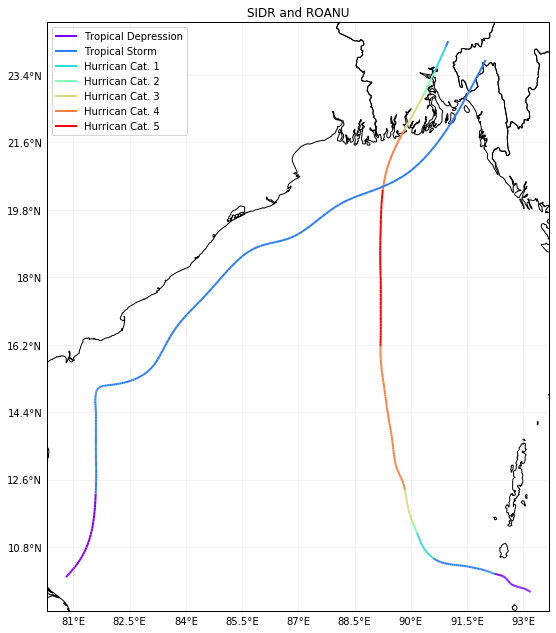

In [2]:
%matplotlib inline
# 1: tracks retrieval
from climada.hazard import TCTracks

tr_usa = TCTracks()
tr_usa.read_ibtracs_netcdf(provider='usa', storm_id=['2007314N10093', '2016138N10081']) # SIDR 2007 and ROANU 2016
tr_usa.equal_timestep(0.5)
ax = tr_usa.plot()
ax.get_legend()._loc = 2 # correct legend location
ax.set_title('SIDR and ROANU'); # set title

In [3]:
# 2: wind gusts computation
from climada.hazard import TropCyclone, Centroids

# define centroids raster
min_lat, max_lat, min_lon, max_lon = 20, 27, 88.5, 92.5
cent_bang = Centroids()
cent_bang.set_raster_from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.015)
cent_bang.check()

tc_bang = TropCyclone()
tc_bang.set_from_tracks(tr_usa, centroids=cent_bang)

2019-09-13 08:22:45,251 - climada.hazard.centroids.centr - DEBUG - Setting dist_coast 125424 points.
2019-09-13 08:22:47,701 - climada.hazard.trop_cyclone - INFO - Mapping 2 tracks to 125424 centroids.
2019-09-13 08:22:52,663 - climada.hazard.trop_cyclone - DEBUG - Append events.
2019-09-13 08:22:52,762 - climada.hazard.trop_cyclone - DEBUG - Compute frequency.


In [4]:
# 3: surge computation
from climada.hazard import TCSurge

ts_bang = TCSurge()
ts_bang.set_from_winds(tc_bang, dem_product='SRTM3')
# The execution time the first time is long, since the DEM files are being downloaded by the elevation library

2019-09-13 08:22:52,772 - climada.hazard.centroids.centr - DEBUG - Setting elevation of raster with bounds (88.4925, 19.9875, 92.5125, 27.0075).
2019-09-13 08:23:31,664 - climada.hazard.tc_surge - INFO - Restricting to centroids in elevation range ]0..10] m and closer than 50 km to coast with a decay of 0.2 m/km inland.


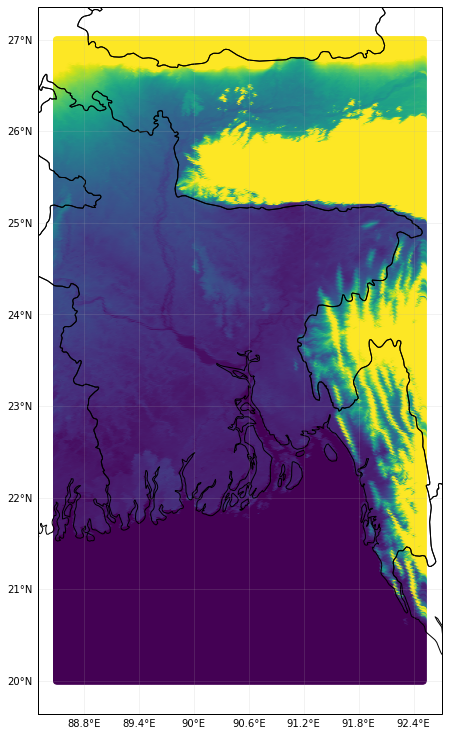

In [5]:
# plot elevation of the raster
ts_bang.centroids.plot(c=ts_bang.centroids.elevation, vmin=-3, vmax=100)

Text(0.5, 1, 'Surge SIDR 2007')

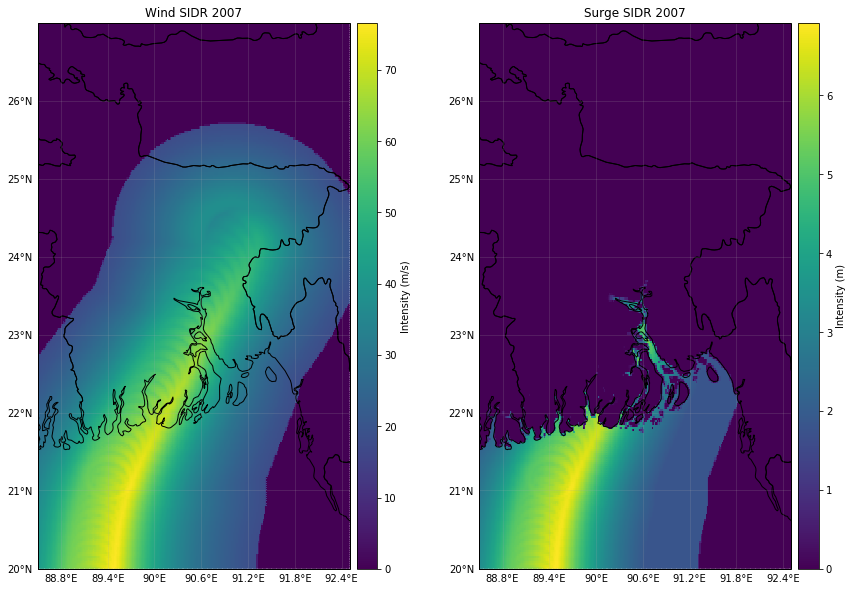

In [6]:
# plot wind and surge SIDR
from climada.util.plot import make_map

fig, ax = make_map(2, figsize=(14, 14))
tc_bang.plot_intensity(1, axis=ax[0])
ts_bang.plot_intensity(1, axis=ax[1])
ax[0].set_title('Wind SIDR 2007')
ax[1].set_title('Surge SIDR 2007')

Text(0.5, 1, 'Surge ROANU 2016')

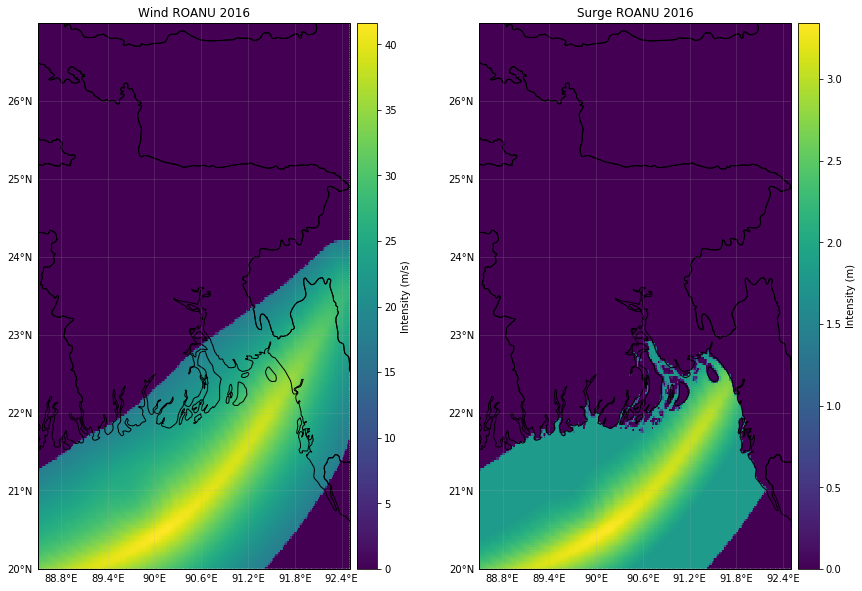

In [7]:
# plot wind and surge ROANU
from climada.util.plot import make_map

fig, ax = make_map(2, figsize=(14, 14))
tc_bang.plot_intensity(2, axis=ax[0])
ts_bang.plot_intensity(2, axis=ax[1])
ax[0].set_title('Wind ROANU 2016')
ax[1].set_title('Surge ROANU 2016')